# OncodriveCLUSTL

In [1]:
%matplotlib inline

import gzip
from collections import defaultdict

import numpy as np
import pandas as pd
from intervaltree import IntervalTree
from scipy.signal import argrelmax
import math as m

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from oncodcl_funct import *

### Automatically incorporates changes in the *oncodcl_funct* module 

In [2]:
%load_ext autoreload
%autoreload 2

#### Load parameters

In [3]:
# Smoothing
genemut = 2
smoothw = 50

# Clustering
clusterw = 50
clustermut = 2
clusterscore = 'nobias' # 'nmutations', 'genelenght', 'nobias'

### Parse regions


Why do some gene and transcript ids start with ENSGR or ENSTR in the GTF/GFF3?

The Ensembl ids, by convention, are made of a species index ("ENS" for human and "ENSMUS" for mouse) followed by a feature type indicator ("G" for gene, "T" for transcript, "E" for exon, "P" for translation) and an 11-number figure.

The GENCODE GTF/GFF3 files make an exception to this rule in the case of the so called "pseudoautosomal regions" (PAR) of chromosome Y. The gene annotation in these regions is identical between chromosomes X and Y. Ensembl do not provide different feature ids for both chromosomes. The Ensembl GTF file only includes this annotation once, for chromosome X. However, we decided that the GENCODE GTF/GFF3 files would include the annotation in the PAR regions of both chromosomes.

Since the GTF convention dictates that feature ids have to be unique for different genome regions, we slightly modify the Ensembl feature id by replacing the first zero with an "R". Thus, "ENSG00000182378.10" in chromosome X becomes "ENSGR0000182378.10" in chromosome Y.

Please note that this applies until release 24. From release 25, the PAR genes and transcripts have "_PAR_Y" appended to their ids.

This annotation is also labeled using the tag "PAR".

https://www.gencodegenes.org/faq.html


In [4]:
input_regions = '/home/carnedo/projects/oncodriveclustl/inputs/regions/02_cds.regions.gz'

In [5]:
%%time
trees, regions_d, strands_d = regions(input_regions)

CPU times: user 14.5 s, sys: 84 ms, total: 14.6 s
Wall time: 14.6 s


### Read mutations file and intersect with regions

In [6]:
input_mutations = '/home/carnedo/projects/oncodriveclustl/inputs/mutations/pancanatlas/SKCM.txt'

In [7]:
%%time
mutations_d = read_mutations(input_mutations, trees)

CPU times: user 9.88 s, sys: 16 ms, total: 9.9 s
Wall time: 9.89 s


### Smooth

In [8]:
%%time
total_regions = defaultdict(dict)
for gene in regions_d.keys():
    # Analyze only genes with mutations >= n mutations
    if len(mutations_d[gene]) >= genemut:
        region_info = smoothing(symbol=gene, regions=regions_d, mutations=mutations_d[gene], window=smoothw)
        # dictionary with regions of all genes
        total_regions[region_info['symbol']] = region_info

len(total_regions.keys())

CPU times: user 3min 30s, sys: 452 ms, total: 3min 31s
Wall time: 3min 31s


## Clusters

- Find local maximum and minimum after smoothing for whole cds, according to smoothing score
- Define raw clusters: min(left), max, min(right) ----> Add filter? (ex. clusters wit max > smoothing score of 1 mutation)
- Starting from first maximum in the sequence, search for other relative maximum close to its min(right) border. 
- If there is one, check which of both maximum has a higher smoothing score and merge clusters by updating borders of the highest maximum. The lowest maximum (cluster) is removed from the dictionary of clusters. Iterate through all clusters until no updates are observed. 
- Filter clusters, minimum n mutations. Concerns: genes without clusters! 
- Score clusters. Two scores implemented: using position of smoothing maximum or mutation maximum within the cluster.

Questions: 
- Clusters calculation assuming + strand? YES ---> Take into account for plots

In [9]:
%%time
total_clusters = defaultdict(dict)

for gene in total_regions.keys():
    clusters = clustering(regions=total_regions[gene], mutations=mutations_d[gene], window=clusterw, cutoff=clustermut, mode=clusterscore)
    if len(clusters.keys()) != 0: 
        total_clusters[gene] = clusters
    
print(len(total_clusters.keys()))

12864
CPU times: user 54.3 s, sys: 72 ms, total: 54.4 s
Wall time: 54.5 s


In [10]:
print(total_clusters['NRAS'])

{0: {'n_mutations': 117, 'max': [387, 4.1769383371525972], 'min_l': [359, 0.0], 'score': 101.52699825132694, 'min_r': [440, 0.0]}, 1: {'n_mutations': 7, 'max': [534, 0.25070111049337263], 'min_l': [506, 0.0], 'score': 4.3284271247461898, 'min_r': [562, 0.0]}}


## Output results

### Read CGC genes

In [11]:
CGC = set([line.split('\t')[0] for line in open('/home/carnedo/projects/oncodriveclustl/inputs/CGC/CGCMay17_cancer_types_TCGA.tsv', 'r')])

### Tables

In [12]:
out = '/home/carnedo/projects/oncodriveclustl/outputs/'

In [13]:
#### Print table
clusters_table = out+'CLUSTER_'+str(genemut)+'_'+str(clustermut)+'_'+str(smoothw)+'_'+str(clusterw)+'_'+str(clusterscore)+'.tab'

with open(clusters_table, 'w') as fd:
    fd.write('Gene\tCluster\tMin_l\tMax\tMin_r\tWidth\tMut\tTotalmut\tScore\n')
    for gene, clusters in sorted(total_clusters.items()): 
        for cluster, values in clusters.items(): 
            if values['min_l'] != [] and values['min_r'] != []: 
                width = abs(values['min_l'][0] - values['min_r'][0])
                fd.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%.4f\n" %(gene, cluster, values['min_l'][0], values['max'][0], values['min_r'][0], width, values['n_mutations'], len(mutations_d[gene]), values['score']))
            elif values['min_l'] == []: 
                width = abs(values['max'][0] - values['min_r'][0])
                fd.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%.4f\n" %(gene, cluster, values['min_l'], values['max'][0], values['min_r'][0], width, values['n_mutations'], len(mutations_d[gene]), values['score']))
            elif values['min_r'] == []: 
                width = abs(values['min_l'][0] - values['max'][0])
                fd.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%.4f\n" %(gene, cluster, values['min_l'][0], values['max'][0], values['min_r'], width, values['n_mutations'], len(mutations_d[gene]), values['score']))


In [14]:
df = pd.read_csv(clusters_table, sep='\t', header=0)
df['CGC'] = df['Gene'].map(lambda x: x in CGC)
df.sort_values(by=['Score', 'CGC'], ascending=[False, False], inplace=True)
df.to_csv(path_or_buf=clusters_table, sep='\t', na_rep='')

In [15]:
df.head(n=15)

,Gene,Cluster,Min_l,Max,Min_r,Width,Mut,Totalmut,Score,CGC
4082,BRAF,2,495,523,608,113,247,269,228.4156,True
26102,NRAS,0,359,387,440,81,117,124,101.5270,True
17718,IDH1,4,827,854,880,53,17,23,16.4142,True
36458,SLC27A5,0,385,412,451,66,18,21,15.2537,False
22159,MAP2K1,1,327,371,414,87,20,28,15.0206,True
3791,BCL2L12,1,0,50,77,77,17,23,12.1217,False
32772,RAC1,1,15,86,125,110,18,20,11.8776,True
31469,PPP6C,1,80,125,166,86,15,29,11.0161,True
34093,RQCD1,1,368,394,420,52,10,13,10.0000,False
31213,POTEH,3,640,666,721,81,10,39,9.0000,False


In [16]:
df.to_csv(path_or_buf=clusters_table, sep='\t', na_rep='')

## Genes

In [17]:
genes_sum = defaultdict()

for gene, value in total_clusters.items(): 
    result = score_genes(clusters=value, mode='sum')
    genes_sum[gene] = result

In [18]:
genes_table = out+'GENES_'+str(genemut)+'_'+str(clustermut)+'_'+str(smoothw)+'_'+str(clusterw)+'_'+str(clusterscore)+'_'+'sum'+'.tab'

with open(genes_table, 'w') as fd:
    fd.write('Gene\tLength\tClusters\tMutations\tScore\n')
    for gene, result in genes_sum.items(): 
            fd.write("%s\t%s\t%s\t%s\t%s\n" %(gene, len(total_regions[gene]['genomic']), result['n_clusters'], len(mutations_d[gene]), result['score']))
         
df = pd.read_csv(genes_table, sep='\t', header=0)
df['CGC'] = df['Gene'].map(lambda x: x in CGC)
df.sort_values(by=['Score', 'CGC'], ascending=[False, False], inplace=True)
df.to_csv(path_or_buf=genes_table, sep='\t', na_rep='')
df.head(n=15)

,Gene,Length,Clusters,Mutations,Score,CGC
7719,TTN,114788,398,1714,363.545375,False
12184,BRAF,2337,5,269,233.699666,True
3405,MUC16,43605,223,1186,220.723853,False
1525,NRAS,571,2,124,105.855425,True
532,DNAH5,13951,74,532,87.341194,False
6109,PCLO,15656,77,405,79.543635,False
231,XIRP2,12303,48,213,59.261502,False
3830,DNAH7,12288,51,232,59.009892,False
10391,DNAH8,14252,54,205,57.746706,False
12032,GPR98,19137,62,261,55.127780,False


In [19]:
genes_mean = defaultdict()

for gene in list(total_clusters.keys()): 
    result = score_genes(total_clusters[gene],  mode='mean')
    genes_mean[gene] = result

In [20]:
genes_table = out+'GENES_'+str(genemut)+'_'+str(clustermut)+'_'+str(smoothw)+'_'+str(clusterw)+'_'+str(clusterscore)+'_'+'mean'+'.tab'

with open(genes_table, 'w') as fd:
    fd.write('Gene\tLength\tClusters\tMutations\tScore\n')
    for gene, result in genes_mean.items(): 
        fd.write("%s\t%s\t%s\t%s\t%s\n" %(gene, len(total_regions[gene]['genomic']), result['n_clusters'], len(mutations_d[gene]), result['score']))
         
df = pd.read_csv(genes_table, sep='\t', header=0)
df['CGC'] = df['Gene'].map(lambda x: x in CGC)
df.sort_values(by=['Score', 'CGC'], ascending=[False, False], inplace=True)
df.to_csv(path_or_buf=genes_table, sep='\t', na_rep='')
df.head(n=15)

,Gene,Length,Clusters,Mutations,Score,CGC
1525,NRAS,571,2,124,52.927713,True
12184,BRAF,2337,5,269,46.739933,True
4675,RAC1,640,1,20,11.877612,True
12561,IDH1,1250,2,23,9.207107,True
4602,SLC27A5,2080,2,21,8.126845,False
11384,MAP2K1,1231,3,28,6.419666,True
3049,RQCD1,1046,2,13,5.801777,False
8660,BCL2L12,1038,3,23,5.227442,False
12861,AKR1B1,958,1,9,5.000000,False
5569,CCDC28A,828,1,13,4.339691,False


In [21]:
genes_wmean = defaultdict()

for gene in list(total_clusters.keys()): 
    result = score_genes(total_clusters[gene],  mode='wmean')
    genes_wmean[gene] = result

In [22]:
genes_table = out+'GENES_'+str(genemut)+'_'+str(clustermut)+'_'+str(smoothw)+'_'+str(clusterw)+'_'+str(clusterscore)+'_'+'wmean'+'.tab'

with open(genes_table, 'w') as fd:
    fd.write('Gene\tLength\tClusters\tMutations\tScore\n')
    for gene, result in genes_wmean.items(): 
        fd.write("%s\t%s\t%s\t%s\t%s\n" %(gene, len(total_regions[gene]['genomic']), result['n_clusters'], len(mutations_d[gene]), result['score']))
         
df = pd.read_csv(genes_table, sep='\t', header=0)
df['CGC'] = df['Gene'].map(lambda x: x in CGC)
df.sort_values(by=['Score', 'CGC'], ascending=[False, False], inplace=True)
df.to_csv(path_or_buf=genes_table, sep='\t', na_rep='')
df.head(n=15)

,Gene,Length,Clusters,Mutations,Score,CGC
1525,NRAS,571,2,124,0.665357,True
12184,BRAF,2337,5,269,0.418180,True
12561,IDH1,1250,2,23,0.174082,True
4602,SLC27A5,2080,2,21,0.120460,False
3049,RQCD1,1046,2,13,0.109743,False
4675,RAC1,640,1,20,0.107978,True
11384,MAP2K1,1231,3,28,0.082310,True
2973,YIPF1,1005,1,5,0.076321,False
8660,BCL2L12,1038,3,23,0.074422,False
2291,MAFG,488,1,2,0.074074,False


### Plot

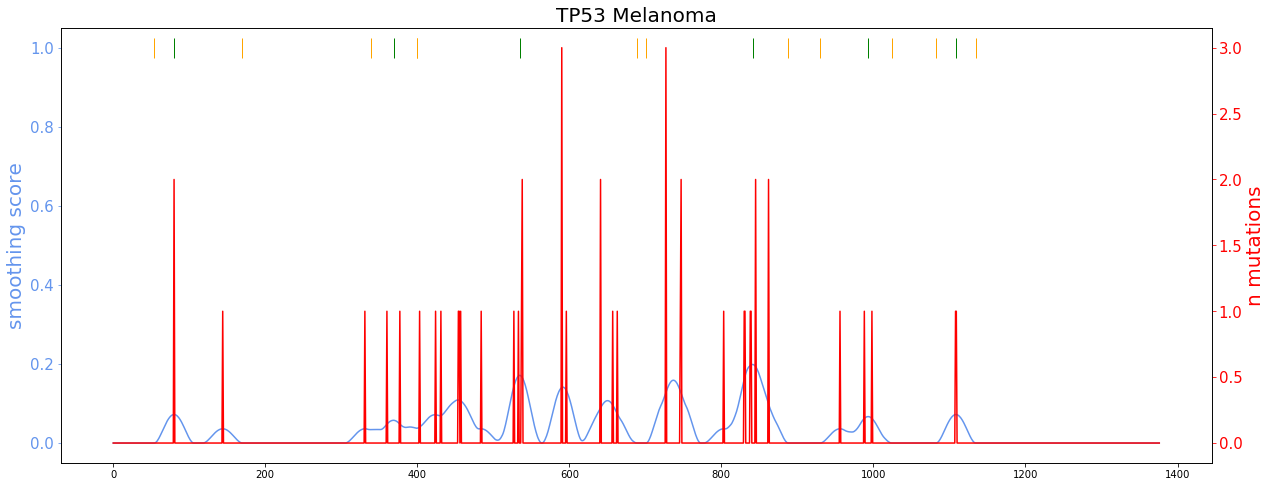

In [23]:
# plot clusters 

gene = 'TP53'
plot = out+'/figures/'+gene+'_'+str(genemut)+'_'+str(clustermut)+'_'+str(smoothw)+'_'+str(clusterw)+'_'+str(clusterscore)+'.png'

plot_max = np.zeros(len(total_regions[gene]['binary']))
plot_min_l = np.zeros(len(total_regions[gene]['binary']))
plot_min_r = np.zeros(len(total_regions[gene]['binary']))

for key, value in total_clusters[gene].items(): 
    plot_max[value['max'][0]]+=1
    plot_min_l[value['min_l'][0]]+=1
    plot_min_r[value['min_r'][0]]+=1

# Change 0 to nan for matplotlib        
plot_max[ plot_max==0.0 ] = np.nan
plot_min_l[ plot_min_l==0.0 ] = np.nan 
plot_min_r[ plot_min_r==0.0 ] = np.nan


if strands_d[gene] == '+':
    binary = total_regions[gene]['binary']
    mutations = total_regions[gene]['mutations']
    
elif strands_d[gene] == '-': 
    binary = total_regions[gene]['binary'][::-1]
    mutations = total_regions[gene]['mutations'][::-1]
    plot_max = plot_max[::-1]
    plot_min_l = plot_min_l[::-1]
    plot_min_r = plot_min_r[::-1]

plt.figure(figsize=(26, 8))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=4)


ax1.plot(binary, c='cornflowerblue')
ax1.set_ylabel('smoothing score', color='cornflowerblue', fontsize=20)

ax2 = ax1.twinx()
ax2.plot(mutations, c='red')
ax2.set_ylabel('n mutations', color='red', fontsize=20)


ax1.plot(plot_max,'|', ms=20, c='green')
ax1.plot(plot_min_l,'|', ms=20, c='orange')
ax1.plot(plot_min_r,'|', ms=20, c='orange')

length = len(total_regions[gene]['binary'])

ax1.tick_params('y', colors='cornflowerblue', labelsize=15)
ax2.tick_params('y', colors='red', labelsize=15)

plt.title('TP53 Melanoma', fontsize=20)
#ax1.set_xlabel('Nucleotides', fontsize=20)
plt.savefig(plot)